# Кредитный скоринг

### TODO:

1. Описание задачи
2. Подключение библиотек и скриптов
3. Пути к директориям и файлам
4. Стек функций


[5. ЗАГРУЗКА ДАННЫХ:](#load)
   - Описание датасета
   - Приведение типов данных

[6. EXPLORATORY DATA ANALYSIS:](#eda) 
   - Распредение целевой переменной
   - Анализ признаков: количественные, категориальные
   - Выделение целевой переменной и групп признаков
   - Анализ зависимости целевой переменной от признаков

[7. DATA PREPROCESSING:](#preprocessing)
   - Обработка пропусков
   - Обработка выбросов

[8. Генерация новых признаков](#newfeatures)

9. Отбор признаков (с учётом генерированных)
10. Сохранение подготовленного датасета

[14. ПОСТРОЕНИЕ МОДЕЛИ и оценка качества:](#model)

11. Нормализация данных
12. Разбиение на train и test
13. Балансировка данных

   - Обучение модели
   - Выбор порога вероятности(threshold) для определения класса
   - Важность признаков
   - Обучение  модели с учётом важности признаков

[15. Предсказания на тестовой выборке](#test)
   - Сохранение предсказаний
    

   

### Описание задачи

Требуется, на основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту.

Выполнить прогноз для примеров из тестового датасета.

**Целевая переменная**:
Credit Default - факт невыполнения кредитных обязательств


### Подключение библиотек и скриптов 

In [36]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from catboost import CatBoostClassifier

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
rcParams.update({'font.size': 12})
rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format='svg'

### Пути к директориям и файлам

In [37]:
TRAIN_DATASET_PATH = 'course_project_train.csv'
TEST_DATASET_PATH = 'course_project_test.csv'
PREP_DATASET_PATH = 'course_project_data_prep.csv'

### Стек функций

In [38]:
# функция, чтобы уменьшить объём памяти, занимаемый данными

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [65]:
# функция для приведения типов данных

def dtype_conversion(df):
    for feature in df.select_dtypes(include='category').columns:
        df[feature] = df[feature].astype(str)
    return df

In [39]:
# функция для баналсировки классов

def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [40]:
# функция выбора порога вероятности(threshold) для определения класса

def show_proba_calibration_plots(y_predicted_proba, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_proba, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_proba > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_proba > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_proba > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [41]:
# функция, показывающая отчёт по метрикам качества

def get_classification_report(y_train_true, y_train_pred, y_valid_true, y_valid_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('VALID\n\n' + classification_report(y_valid_true, y_valid_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_valid_true, y_valid_pred))

In [42]:
# функция для конвертации предсказанных значений в основной класс (0 или 1)

def convertation_to_main_class(proba, threshold):
    function = lambda x: 0 if x < threshold else 1
    vectorize_function = np.vectorize(function)
    return vectorize_function(proba)

In [117]:
# функция для отображения важности признаков

def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
       
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    
    sns.barplot(x=feature_importances['importance'], y=feature_importances['feature'])
    
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

# Загрузка данных  <a class='anchor' id='load'>

### Описание датасета

* **Home Ownership** - домовладение
* **Annual Income** - годовой доход
* **Years in current job** - количество лет на текущем месте работы
* **Tax Liens** - налоговые обременения
* **Number of Open Accounts** - количество открытых счетов
* **Years of Credit History** - количество лет кредитной истории
* **Maximum Open Credit** - наибольший открытый кредит
* **Number of Credit Problems** - количество проблем с кредитом
* **Months since last delinquent** - количество месяцев с последней просрочки платежа
* **Bankruptcies** - банкротства
* **Purpose** - цель кредита
* **Term** - срок кредита
* **Current Loan Amount** - текущая сумма кредита
* **Current Credit Balance** - текущий кредитный баланс
* **Monthly Debt** - ежемесячный долг
* **Credit Score** - кредитный рейтинг
* **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [44]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


In [45]:
test_df = pd.read_csv(TEST_DATASET_PATH)
test_df.tail()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
2495,Home Mortgage,1020053.0,10+ years,0.0,14.0,29.1,559152.0,1.0,68.0,1.0,debt consolidation,Short Term,99999999.0,162735.0,15046.0,745.0
2496,Home Mortgage,NaN,2 years,0.0,15.0,17.0,1737780.0,0.0,77.0,0.0,debt consolidation,Short Term,468512.0,1439269.0,32996.0,NaN
2497,Home Mortgage,1171806.0,2 years,0.0,48.0,12.8,1706430.0,0.0,NaN,0.0,debt consolidation,Short Term,430496.0,676438.0,36912.0,695.0
2498,Rent,723520.0,10+ years,0.0,14.0,28.8,945780.0,0.0,NaN,0.0,debt consolidation,Short Term,257774.0,391248.0,13506.0,744.0
2499,Rent,1694439.0,10+ years,0.0,12.0,18.4,1199748.0,1.0,72.0,0.0,debt consolidation,Long Term,763004.0,559531.0,23440.0,6820.0


In [46]:
train_df.shape, test_df.shape

((7500, 17), (2500, 16))

In [47]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [48]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

В тестовом датасете пропуски там же, где и в тренировочном. Обрабатывать его будем так же, как и тренировочный

In [49]:
train_df = reduce_mem_usage(train_df)

Memory usage of dataframe is 0.97 MB
Memory usage after optimization is: 0.38 MB
Decreased by 60.9%


In [50]:
test_df = reduce_mem_usage(test_df)

Memory usage of dataframe is 0.31 MB
Memory usage after optimization is: 0.13 MB
Decreased by 58.9%


### Приведение типов данных

In [51]:
train_df.dtypes

Home Ownership                  category
Annual Income                    float32
Years in current job            category
Tax Liens                        float32
Number of Open Accounts          float32
Years of Credit History          float32
Maximum Open Credit              float32
Number of Credit Problems        float32
Months since last delinquent     float32
Bankruptcies                     float32
Purpose                         category
Term                            category
Current Loan Amount              float32
Current Credit Balance           float32
Monthly Debt                     float32
Credit Score                     float32
Credit Default                      int8
dtype: object

In [90]:
train_df = dtype_conversion(train_df)
test_df = dtype_conversion(test_df)

#  Exploratory Data Analysis <a class='anchor' id='eda'>


### Распределение целевой переменной

In [69]:
train_df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Видим, что класс 0 составляет 71,83% всех значений, а класс 1 28,17%. Понадобится балансировка классов.

Визуализируем распределение целевой переменной:

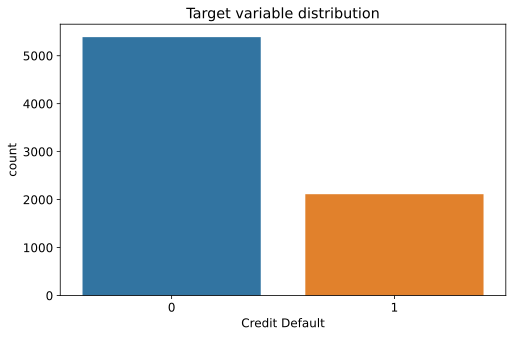

In [70]:
plt.figure(figsize=(8, 5))

sns.countplot(x=train_df['Credit Default'], data=train_df)

plt.title('Target variable distribution')
plt.show()

### Анализ признаков

#### Количественные признаки

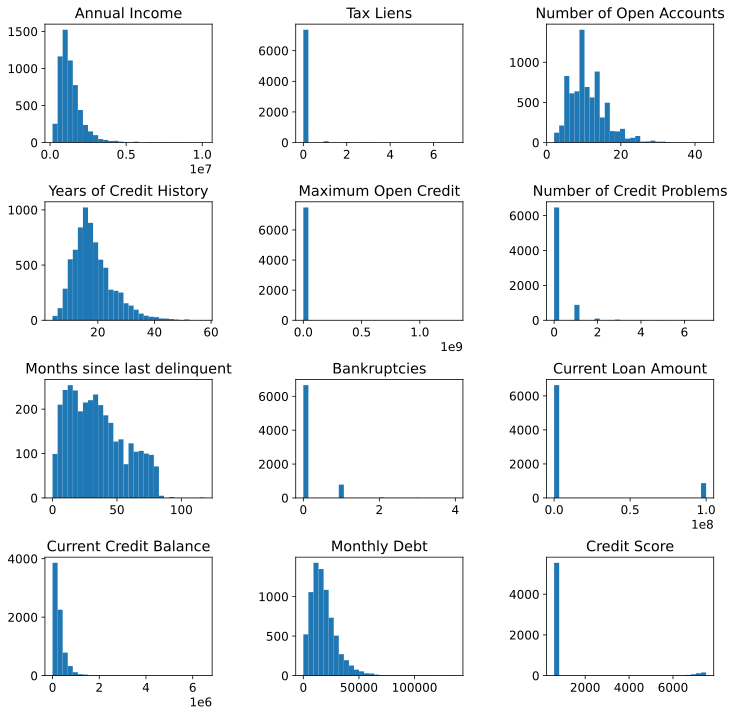

In [71]:
train_df.select_dtypes(include='float32').hist(figsize=(12,12), bins=30, grid=False)
plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [72]:
train_df.select_dtypes(include='float32').describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,3419.000000,7486.000000,7500.0,7.500000e+03,7500.000000,5943.000000
mean,1.366390e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,34.692600,0.117152,11873135.0,2.898332e+05,18314.453125,1151.087524
std,8.453384e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,21.688801,0.347197,31926302.0,3.178713e+05,11926.758789,1604.447510
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,16.000000,0.000000,180169.0,1.142565e+05,10067.500000,711.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,32.000000,0.000000,309573.0,2.093230e+05,16076.500000,731.000000
75%,1.640137e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,50.000000,0.000000,519882.0,3.604062e+05,23818.000000,743.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000


Не вижу каких-либо аномалий в распределениях количественных признаков

#### Категориальные признаки

In [74]:
train_df.select_dtypes(include='object')

,Home Ownership,Years in current job,Purpose,Term
0,Own Home,nan,debt consolidation,Short Term
1,Own Home,10+ years,debt consolidation,Long Term
2,Home Mortgage,8 years,debt consolidation,Short Term
3,Own Home,6 years,debt consolidation,Short Term
4,Rent,8 years,debt consolidation,Short Term
...,...,...,...,...
7495,Rent,< 1 year,other,Short Term
7496,Home Mortgage,1 year,debt consolidation,Long Term
7497,Rent,6 years,buy a car,Short Term
7498,Home Mortgage,nan,debt consolidation,Short Term


In [76]:
for cat_colname in train_df.select_dtypes(include='object').columns:
    print(f'***{cat_colname}***\n{train_df[cat_colname].value_counts()}\n')

***Home Ownership***
Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64

***Years in current job***
10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
nan           371
8 years       339
9 years       259
Name: Years in current job, dtype: int64

***Purpose***
debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

***Term***
Short Term    5556
Long Term     1944
Name: Term, dtype: int64



Не вижу каких-либо аномалий и в данных категориальных признаков

### Выделение целевой переменной и групп признаков

In [78]:
train_df.select_dtypes(include='object').columns.tolist()

['Home Ownership', 'Years in current job', 'Purpose', 'Term']

In [79]:
train_df.select_dtypes(include='float32').columns.tolist()

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [81]:
target = ['Credit Default']
train_df_num_features = ['Annual Income', 'Tax Liens', 'Number of Open Accounts', 'Years of Credit History', 
                         'Maximum Open Credit', 'Number of Credit Problems', 'Months since last delinquent',
                         'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance', 'Monthly Debt',
                         'Credit Score']
train_df_cat_features = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']

### Анализ зависимостей целевой переменной и признаков

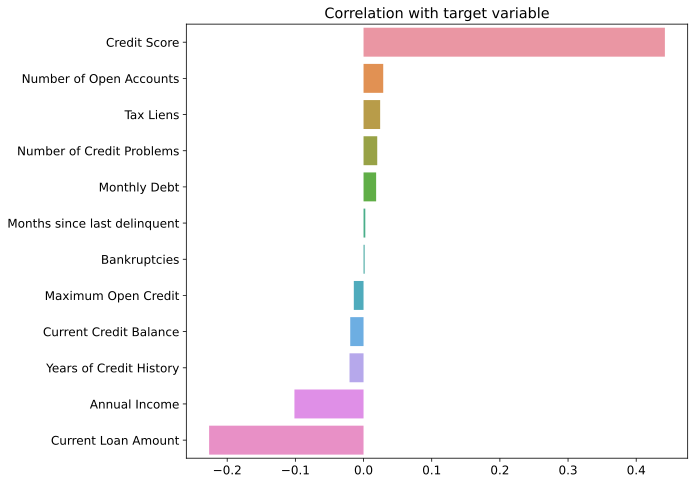

In [83]:
corr_with_target = train_df[train_df_num_features + target].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(9, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

Видим, что Credit Score (кредитный рейтинг) очень полезный признак, а вот Months since last delinquent (количество месяцев с последней просрочки платежа) и Bankruptcies (банкротства) на целевой признак почти не влияют

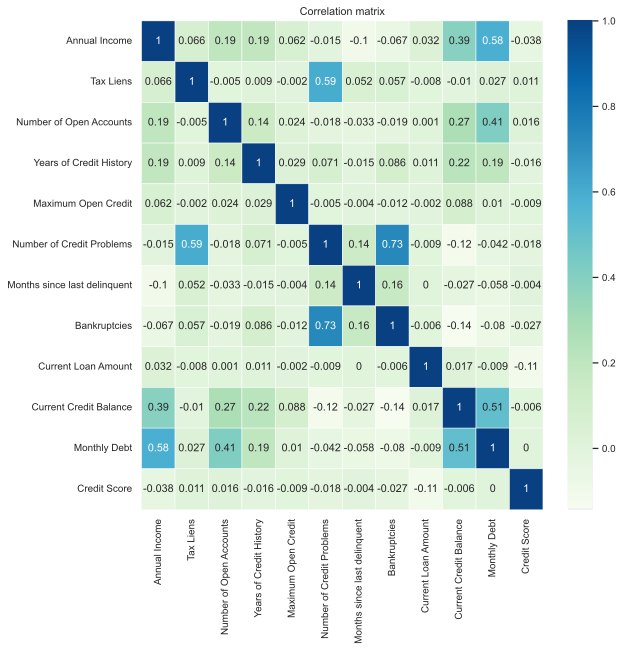

In [84]:
plt.figure(figsize = (9,9))

sns.set(font_scale=0.9)
sns.heatmap( train_df[train_df_num_features].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

По цифрам не вижу сильной линейной зависимости между признаки. Все признаки оставим

# Data Preprocessing<a class='anchor' id='preprocessing'>

## Oбработка пропусков

In [85]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float32
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float32
 4   Number of Open Accounts       7500 non-null   float32
 5   Years of Credit History       7500 non-null   float32
 6   Maximum Open Credit           7500 non-null   float32
 7   Number of Credit Problems     7500 non-null   float32
 8   Months since last delinquent  3419 non-null   float32
 9   Bankruptcies                  7486 non-null   float32
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float32
 13  Cur

In [88]:
# функция, заполняющая пропуски 

def DataPipeline_fill_NAN(df):
    """Пропуски Annual Income"""
    median_annual_income_by_home_and_job_years = df.groupby(['Home Ownership', 'Years in current job'])[['Annual Income']]\
                        .median().rename(columns={'Annual Income': 'Median Annual Income By Home And Job Years'})
    median_annual_income_by_home = df.groupby('Home Ownership')[['Annual Income']]\
      .median().rename(columns={'Annual Income': 'Median Annual Income By Home'})
    
    df = pd.merge(df, median_annual_income_by_home_and_job_years, on = ['Home Ownership', 'Years in current job'], how = 'left').set_index(df.index)
    df = pd.merge(df, median_annual_income_by_home, on = 'Home Ownership', how = 'left').set_index(df.index)
    
    df['Annual Income'] = df['Annual Income'].fillna(df['Median Annual Income By Home And Job Years'])
    df['Annual Income'] = df['Annual Income'].fillna(df['Median Annual Income By Home'])
    
    df = df.drop('Median Annual Income By Home And Job Years', axis = 1)
    df = df.drop('Median Annual Income By Home', axis = 1)
    
    """Пропуски Years in current job"""
    df['Years in current job'] = df['Years in current job'].fillna(df['Years in current job'].mode()[0])
    
    """Пропуски Months since last delinquent"""
    df['Months since last delinquent'] = df['Months since last delinquent'].fillna(0)
    
    """Пропуски Bankruptcies"""
    df['Bankruptcies'] = df['Bankruptcies'].fillna(df['Bankruptcies'].mode()[0])
    
    """Пропуски Credit Score"""
    median_credit_score = df.groupby('Number of Credit Problems')[['Credit Score']].median()\
                          .rename(columns={'Credit Score': 'Median Credit Score'})
    df = pd.merge(df, median_credit_score, on = 'Number of Credit Problems', how = 'left').set_index(df.index)
    df['Credit Score'] = df['Credit Score'].fillna(df['Median Credit Score'])
    df = df.drop('Median Credit Score', axis = 1)
    return df

In [91]:
train_df = DataPipeline_fill_NAN(train_df)
test_df = DataPipeline_fill_NAN(test_df)

In [92]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float32
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float32
 4   Number of Open Accounts       7500 non-null   float32
 5   Years of Credit History       7500 non-null   float32
 6   Maximum Open Credit           7500 non-null   float32
 7   Number of Credit Problems     7500 non-null   float32
 8   Months since last delinquent  7500 non-null   float32
 9   Bankruptcies                  7500 non-null   float32
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float32
 13  Cur

### Обработка выбросов

In [93]:
train_df.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.0000,7500.000000,7500.000000,7500.0,7.500000e+03,7500.000000,7500.000000,7500.000000
mean,1.326260e+06,0.030133,11.130934,18.317446,9.451526e+05,0.1700,15.815200,0.116933,11873135.0,2.898332e+05,18314.453125,1063.922852,0.281733
std,7.630234e+05,0.271613,4.908937,7.041938,1.602614e+07,0.4986,22.648802,0.346901,31926302.0,3.178713e+05,11926.758789,1438.332031,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.0000,0.000000,0.000000,11242.0,0.000000e+00,0.000000,585.000000,0.000000
25%,8.939500e+05,0.000000,8.000000,13.500000,2.792295e+05,0.0000,0.000000,0.000000,180169.0,1.142565e+05,10067.500000,718.000000,0.000000
50%,1.158107e+06,0.000000,10.000000,17.000000,4.781590e+05,0.0000,0.000000,0.000000,309573.0,2.093230e+05,16076.500000,732.000000,0.000000
75%,1.499974e+06,0.000000,14.000000,21.799999,7.935015e+05,0.0000,29.000000,0.000000,519882.0,3.604062e+05,23818.000000,740.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700001,1.304726e+09,7.0000,118.000000,4.000000,100000000.0,6.506797e+06,136679.000000,7510.000000,1.000000


Не вижу аномальных выбросов, оставим так

## Генерация новых признаков <a class='anchor' id='newfeatures'>

In [132]:
# функция добавления новых признаков

def DataPipeline_new_features(df):
    """Доход клиента с учётом ежемесячных выплат"""
    df['Final Annual Income'] = df['Annual Income'] - df['Monthly Debt'] * 12
    
    """Средняя ежемесячная выплата клиентом, которая зависит от общего долга и количества открытых счетов"""
    df['Avg Monthly Debt'] = df['Monthly Debt'] / df['Number of Open Accounts']
    
    return df

In [133]:
train_df = DataPipeline_new_features(train_df)
test_df = DataPipeline_new_features(test_df)

### Сохранение подготовленого датасета

In [97]:
train_df.to_csv(PREP_DATASET_PATH, index=False, encoding='utf-8')

### Отбор признаков ( с учётом генерированных)

In [102]:
train_df.select_dtypes(include='float32').columns

Index(['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Final Annual Income',
       'Avg Monthly Debt'],
      dtype='object')

In [103]:
train_df.select_dtypes(include='object').columns


Index(['Home Ownership', 'Years in current job', 'Purpose', 'Term'], dtype='object')

In [104]:
NUM_FEATURE_NAMES = ['Annual Income', 'Tax Liens', 'Number of Open Accounts',
       'Years of Credit History', 'Maximum Open Credit',
       'Number of Credit Problems', 'Months since last delinquent',
       'Bankruptcies', 'Current Loan Amount', 'Current Credit Balance',
       'Monthly Debt', 'Credit Score', 'Final Annual Income',
       'Avg Monthly Debt']
CAT_FEATURE_NAMES = ['Home Ownership', 'Years in current job', 'Purpose', 'Term']                  
TARGET_NAME = 'Credit Default'

## Нормализация данных

In [105]:
scaler = StandardScaler()

df_norm = train_df.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

train_df= df_norm.copy() 

## Разбиение на train и test

In [106]:
X = train_df.drop(columns=TARGET_NAME)
y = train_df[TARGET_NAME]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=True, test_size=0.3, random_state=41)

## Балансировка данных

In [107]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3774
1    2952
Name: Credit Default, dtype: int64

In [108]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

# Построение модели <a class='anchor' id='model'>

## Обучение модели

In [109]:
model = CatBoostClassifier(n_estimators=500, max_depth=3, silent=True, random_state=41)
model.fit(X_train, y_train, cat_features=CAT_FEATURE_NAMES)

y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.87      0.81      3774
           1       0.79      0.64      0.71      2952

    accuracy                           0.77      6726
   macro avg       0.77      0.75      0.76      6726
weighted avg       0.77      0.77      0.76      6726

VALID

              precision    recall  f1-score   support

           0       0.82      0.83      0.82      1613
           1       0.55      0.54      0.55       637

    accuracy                           0.74      2250
   macro avg       0.69      0.68      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1331  282
1                292  345


## Выбор порога вероятности(threshold) для определения класса

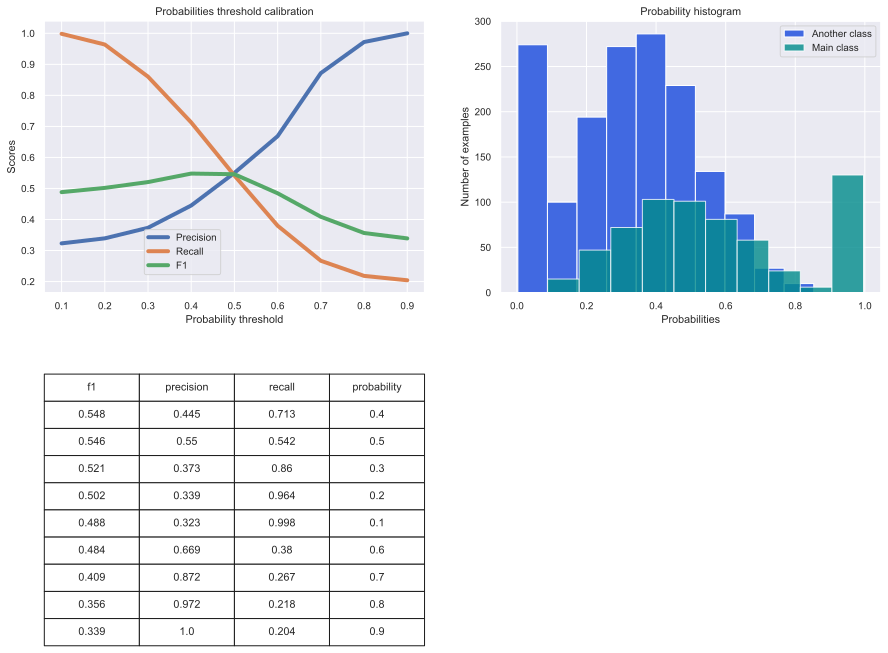

In [110]:
show_proba_calibration_plots(y_valid_pred_proba, y_valid)

## Важность признаков

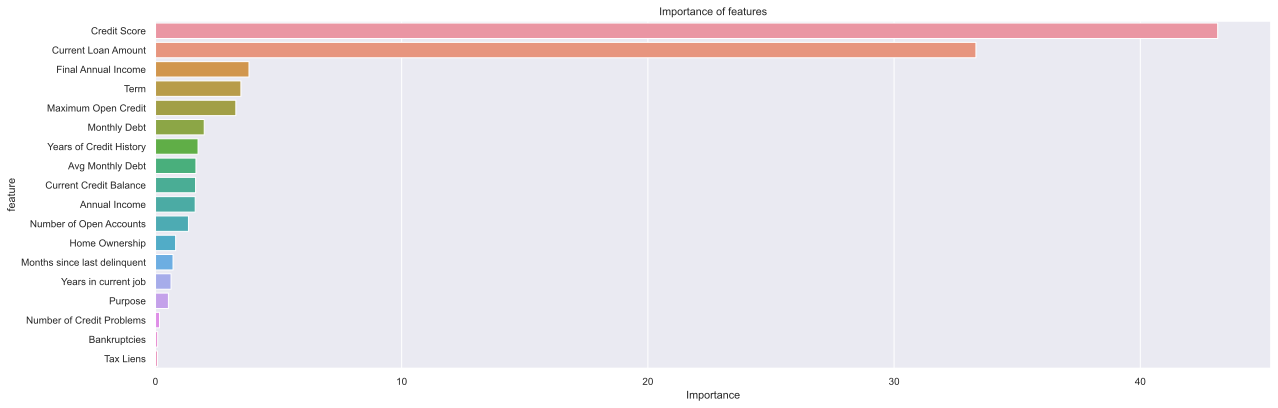

In [118]:
important_features_top = show_feature_importances(X_train.columns, model.feature_importances_, get_top = 9)

Видим, что Credit Score (кредитный рейтинг) и Current Loan Amount (текущая сумма кредита) важные признаки. Из добавленных признаков оба оказались полезными (Avg Monthly Dept, Final Annual Income) 

In [119]:
important_features_top

['Credit Score',
 'Current Loan Amount',
 'Final Annual Income',
 'Term',
 'Maximum Open Credit',
 'Monthly Debt',
 'Years of Credit History',
 'Avg Monthly Debt',
 'Current Credit Balance']

Из категориальных признаков важным оказался только Term (срок кредита), его и оставим.

In [123]:
NEW_CAT_FEATURE_NAMES = ['Term']

### Обучение  модели с учётом важности признаков

In [125]:
final_model = CatBoostClassifier(n_estimators=500, max_depth=3, silent=True, random_state=41)
final_model.fit(X_train[important_features_top], y_train, cat_features=NEW_CAT_FEATURE_NAMES)

y_train_pred = final_model.predict(X_train[important_features_top])
y_valid_pred = final_model.predict(X_valid[important_features_top])
y_valid_pred_proba = final_model.predict_proba(X_valid[important_features_top])

get_classification_report(y_train, y_train_pred, y_valid, y_valid_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.86      0.80      3774
           1       0.78      0.65      0.71      2952

    accuracy                           0.76      6726
   macro avg       0.77      0.75      0.76      6726
weighted avg       0.77      0.76      0.76      6726

VALID

              precision    recall  f1-score   support

           0       0.82      0.81      0.82      1613
           1       0.53      0.56      0.54       637

    accuracy                           0.74      2250
   macro avg       0.68      0.68      0.68      2250
weighted avg       0.74      0.74      0.74      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1304  309
1                283  354


## Предсказания на тестовой выборке<a class='anchor' id='test'>

In [126]:
y_test_pred_proba = final_model.predict_proba(test_df[important_features_top])[:, 1]
y_test_pred = convertation_to_main_class(y_test_pred_proba, threshold = 0.5)

In [130]:
preds = pd.DataFrame()
preds['Credit Default'] = y_test_pred
preds.value_counts()

Credit Default
0                 2486
1                   14
dtype: int64

### Сохранение предсказаний

In [131]:
preds.to_csv('IraLevchenko_predictions.csv', index = False)